# Identificação de Clientes de Alto Valor

## Planejamento da Solução

### Entrada

O problema de negócio
1. Selecionar os mais valiosos clientes para formar o programa de fidelidade "INSIDERS"
2. Conjunto de dados com as vendas de produtos durante 1 ano ( Nov 2015 to Dec 2017 )

### Saída

1. A indicação de pessoas para fazer parte do programa de fidelidade "INSIDERS".
2. Relatório com as respostas para as seguintes perguntas:
- Quem são as pessoas elegíveis para participar do programa de Insiders ?
- Quantos clientes farão parte do grupo ?
- Quais as principais características desses clientes ?
- Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
- Qual a expectativa de faturamento desse grupo para os próximos meses ?
- Quais as condições para uma pessoa ser elegível ao Insiders ?
- Quais as condições para uma pessoa ser removida do Insiders ?
- Qual a garantia que o programa Insiders é melhor que o restante da base ?
- Quais ações o time de marketing pode realizar para aumentar o faturamento ?

### Processo

1. **Quem são as pessoas elegíveis para participar do programa de Insiders ?**
    - O que é ser elegível? O que são clientes de maior valor?
    - Faturamento:
        - Alto Ticket Médio
        - Alto LTV (Life Time Value)
        - Baixo recência
        - Alto basket size (quantidade média de produtos comprados)
        - Baixa probabilidade de Churn
        - Previsão alta de LTV
        - Alta propensão de compra
    - Custo:
        - Baixa taxa de devolução
        
    - Experiência:
        - Alta média de avaliação
2. **Quantos clientes farão parte do grupo?**
     - Número de clientes
     - Porcentagem do total
     
3. **Quais as principais características desses clientes ?**
    - Escrever os principais atributos dos clientes
        - Idade
        - Localização
        - Salário
    - Escrever as principais característica de consumo
        - Atributos de Clusterização

4. **Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?**
    - Faturamento total do ano
    - Faturamento do grupo de Insiders

5. **Qual a expectativa de faturamento desse grupo para os próximos meses ?**
    - LTV do grupo Insiders
    - Série temporais (ARMA, ARIMA, HoltWinter, etc)

6. **Quais as condições para uma pessoa ser elegível ao Insiders ?**
    - Definir a periodicidade (1 mês, 2 meses, 3 meses...)
    - A pessoa precisa de parecido/similiar com outras que já estão no grupo

7. **Quais as condições para uma pessoa ser removida do Insiders ?**
    - Definir a periodicidade (1 mês, 2 meses, 3 meses...)
    - A pessoa não ser parecido/similiar com outras que já estão no grupo    

8. **Qual a garantia que o programa Insiders é melhor que o restante da base ?**
    - Teste A/B
    - Teste A/B de Bayesiano
    - Teste de hipótese
        
9. **Quais ações o time de marketing pode realizar para aumentar o faturamento ?**
    - Desconto
    - Preferências de escolha
    - Produtos exclusivos

# Imports

In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import inflection
import umap
import re
import pickle 

from pandas_profiling      import ProfileReport
from IPython.display       import Image

import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.cm as cm


from sklearn.cluster         import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics         import silhouette_score, silhouette_samples
from sklearn.preprocessing   import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition   import PCA
from sklearn.manifold        import TSNE
from sklearn.ensemble        import RandomForestRegressor
from sklearn.mixture         import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster


from plotly import express as px

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

import optuna

In [2]:
# configurações globais
sns.set_theme()                                                  # gráfico
plt.rcParams['figure.figsize'] = [15, 10]                         # gráfico

## Loading

In [3]:
data = pd.read_csv('datasets/ecommerce.csv', encoding='unicode_escape')

In [4]:
# drop de coluna
data = data.drop('Unnamed: 8', axis=1)

# 1 Descrição dos Dados

In [5]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## 1.1 Renomeando as Colunas

In [6]:
data.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [7]:
old_cols = list(data.columns)

new_cols = []

for c in old_cols:
    new_cols.append(inflection.underscore(c))

data.columns = new_cols

In [8]:
data.columns

Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

## 1.2 Tamanho do Conjunto de Dados 

In [9]:
print(f'Linhas: {data.shape[0]}')
print(f'Colunas: {data.shape[1]}')

Linhas: 541909
Colunas: 8


## 1.3 Tipos dos Dados

In [10]:
data.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   invoice_no    541909 non-null  object 
 1   stock_code    541909 non-null  object 
 2   description   540455 non-null  object 
 3   quantity      541909 non-null  int64  
 4   invoice_date  541909 non-null  object 
 5   unit_price    541909 non-null  float64
 6   customer_id   406829 non-null  float64
 7   country       541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [12]:
data.isnull().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Replace NA's

Para preencher os 'customer_id' faltantes e não perder todas as informações dessas 135080 linhas do DF faremos o seguinte:
Cada compra que não possui customer_id faremos uma associação com invoice_no, de tal forma que cada invoice_no será associado a um customer_id novo.

In [13]:
# customer_id max
data['customer_id'].max()

18287.0

Os novos customer_id serão maiores que 18287, vamos começar a partir de 18500. Assim garantiremos que não haverá repetição de customer_id

In [14]:
# criação de um dicionário com os novos customer_id {'invoice_no': novo_customer_id}
invoice_customer_id_null = list(data[data['customer_id'].isna()]['invoice_no'].drop_duplicates())

customer_id_null_dic = {}
new_customer_id = 18500
for invoice in invoice_customer_id_null:
    customer_id_null_dic[invoice] = new_customer_id
    new_customer_id += 1


In [15]:
# Nova coluna de customer_id, com invoice_no no lugar do customer_id
data['new_customer_id'] = data[['invoice_no', 'customer_id']].apply(lambda x: x['invoice_no'] if 
                                          np.isnan(x['customer_id']) == True else np.nan, axis=1)

In [16]:
data.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,new_customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN


In [17]:
# faz a troca de cada invoice_no pelo novo customer_id com o dicionário criado
data['new_customer_id'] = data['new_customer_id'].map(customer_id_null_dic)

In [18]:
# junta as colunas customer_id e new_customer_id em uma só
data['customer_id'] = data[['customer_id', 'new_customer_id']].apply(lambda x: x['new_customer_id'] 
                                                                     if np.isnan(x['customer_id'])  == True 
                                                                     else x['customer_id'] , axis=1)

In [19]:
# drop new_customer_id
data = data.drop('new_customer_id', axis=1)

In [20]:
data.isnull().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
customer_id        0
country            0
dtype: int64

## 1.6 Troca dos Tipos dos Dados

In [21]:
# invoice_date
data['invoice_date'] = pd.to_datetime(data['invoice_date'], format='%d-%b-%y')

# customer_id
data['customer_id'] = data['customer_id'].astype('int64')


## 1.7 Estatística Descritiva

In [ ]:
num_attributes = data.select_dtypes(include=['int64', 'float64'])
cat_attributes = data.select_dtypes(include=['object'])

## 1.7.1 Atributos Numéricos

In [23]:
# Medidas de Tedência Central - Média e Mediana
tc1 = pd.DataFrame(num_attributes.apply(np.mean)).T
tc2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Medidas de Dispersão - Desvio Padrão, Mínimo, Máximo, Range, Assimetria (skew) e Curtose
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x:  np.max(x) - np.min(x))).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenar
est_desc_num = pd.concat([d2, d3, d4, tc1, tc2, d1, d5, d6]).T.reset_index()

# Renomear
est_desc_num.columns = ['attribute', 'min', 'max', 'range', 'media', 'mediana', 'std', 'skew', 'kurtosis']

In [24]:
est_desc_num

,attribute,min,max,range,media,mediana,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22209.0,9863.00,16564.206981,16249.00,2733.348518,0.410621,-0.824543


#### 1.7.1.1 Investigando os atributos numéricos

Coisas que estão estranhas:
- Quantidade negativa (pode ser devolução)
- Preço unitário igual a zero (pode ser promoção/brinde)

### 1.7.2 Atributos Categóricos

In [25]:
cat_attributes.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


#### 1.7.2.1 Invoice_no

In [26]:
lista = []
for c in data.loc[data['invoice_no'].apply(lambda x: bool(re.search('[a-zA-Z]+', x))), 'invoice_no'].unique():
    lista.append(c[0])
set(lista)

{'A', 'C'}

Todos os invoice_no que começam com a letra 'C' possuem quantity negativo. Isso pode significar 'Cancel', 'Change' ou 'Chargeback'.

In [27]:
data.loc[data['invoice_no'].apply(lambda x: bool(re.search('A.', x))), :]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
299982,A563185,B,Adjust bad debt,1,2017-08-10,11062.06,20997,United Kingdom
299983,A563186,B,Adjust bad debt,1,2017-08-10,-11062.06,20998,United Kingdom
299984,A563187,B,Adjust bad debt,1,2017-08-10,-11062.06,20999,United Kingdom


In [28]:
data[data['unit_price'] < 0]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
299983,A563186,B,Adjust bad debt,1,2017-08-10,-11062.06,20998,United Kingdom
299984,A563187,B,Adjust bad debt,1,2017-08-10,-11062.06,20999,United Kingdom


Todos os inovice_no que começam com 'A' são descritos como 'Adjust bad debt' e 2 deles possuem unit_price negativo. São apenas três linhas, excluiremos esses dados.

In [28]:
df_stock = data[['stock_code', 'quantity']].groupby('stock_code').sum().reset_index()
df_stock[df_stock['quantity'] < 0].head()

,stock_code,quantity
3,10123C,-13
4,10123G,-38
9,10134,-19
46,16053,-102
55,16162L,-4


Existem  produtos que foram mais Cancelados ou Trocados do que comprados.  (!?!?!)

#### 1.7.2.2 Stock_code

In [29]:
data.loc[data['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+', x))), :]['stock_code'].unique()

array(['POST', 'D', 'C2', 'DOT', 'M', 'BANK CHARGES', 'S', 'AMAZONFEE',
       'DCGS0076', 'DCGS0003', 'gift_0001_40', 'DCGS0070', 'm',
       'gift_0001_50', 'gift_0001_30', 'gift_0001_20', 'DCGS0055',
       'DCGS0072', 'DCGS0074', 'DCGS0069', 'DCGS0057', 'DCGSSBOY',
       'DCGSSGIRL', 'gift_0001_10', 'PADS', 'DCGS0004', 'DCGS0073',
       'DCGS0071', 'DCGS0068', 'DCGS0067', 'DCGS0066P', 'B', 'CRUK'],
      dtype=object)

In [30]:
data[data['stock_code'] == 'POST'].sample()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
196382,553842,POST,POSTAGE,2,2017-05-17,18.0,12524,Germany


stock_code = 'POST' pode representar envio de carta.

In [32]:
data[(data['stock_code'] == 'D')].sample()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
108071,C545476,D,Discount,-1,2017-03-01,30.38,14527,United Kingdom


stock_code = 'D' representa algum tipo de desconto que o cliente recebeu.

In [278]:
data[(data['stock_code'] == 'C2')].sample()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
274448,560916,C2,CARRIAGE,1,2017-07-19,50.0,14911,EIRE


stock_code = 'C2' pode representar algum tipo de frete.

In [65]:
data[(data['stock_code'].isin(['M', 'm']))]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
2239,536569,M,Manual,1,2016-11-29,1.25,16274,United Kingdom
2250,536569,M,Manual,1,2016-11-29,18.95,16274,United Kingdom
5684,536865,M,Manual,1,2016-12-01,2.55,18525,United Kingdom
6798,536981,M,Manual,2,2016-12-01,0.85,14723,United Kingdom
7976,537077,M,Manual,12,2016-12-03,0.42,17062,United Kingdom
...,...,...,...,...,...,...,...,...
531432,580956,M,Manual,4,2017-12-04,1.25,17841,United Kingdom
533082,C581009,M,Manual,-1,2017-12-05,125.00,16971,United Kingdom
534308,C581145,M,Manual,-1,2017-12-05,9.95,17490,United Kingdom
538321,581405,M,Manual,3,2017-12-06,0.42,13521,United Kingdom


stock_code = 'M' ou 'm' tem  descrição 'Manual', talvez sejam itens que foram acrescentados manualmente.

In [280]:
data[data['stock_code'] == 'BANK CHARGES'].sample()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
431351,573586,BANK CHARGES,Bank Charges,1,2017-10-29,15.0,14704,United Kingdom


stock_code = 'BANK CHARGES' deve ser alguma taxa de banco, porem são pouquissímos resultados com essa característica, podemos  descarta-los sem nenhuma preocupação.

In [281]:
data[data['stock_code'] == 'PADS']

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
157195,550193,PADS,PADS TO MATCH ALL CUSHIONS,1,2017-04-13,0.001,13952,United Kingdom
279045,561226,PADS,PADS TO MATCH ALL CUSHIONS,1,2017-07-24,0.001,15618,United Kingdom
358655,568158,PADS,PADS TO MATCH ALL CUSHIONS,1,2017-09-23,0.000,16133,United Kingdom
359871,568200,PADS,PADS TO MATCH ALL CUSHIONS,1,2017-09-23,0.001,16198,United Kingdom


stock_code = 'PADS' podemos descartar sem nenhuma preocupação.

In [282]:
data[data['stock_code'] == 'DOT'].sample()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
467436,576339,DOT,DOTCOM POSTAGE,1,2017-11-12,1500.36,14096,United Kingdom


stock_code = 'DOT' é algum tipo de postagem, mas que diferente do 'POST' possui valores bem maiores e apenas  um cliente utilizou esse tipo de postagem (cliente com customer_id = 14096).

In [283]:
data[(data['stock_code'] == 'CRUK')].sample()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
324023,C565382,CRUK,CRUK Commission,-1,2017-08-31,13.01,14096,United Kingdom


CRUK (Cancer Research UK) Commission: Todos os 'stock_code' == 'CRUK' possuem quantity negativa, o que deve significar um desconto/taxa/doação para a instituição Cancer Research UK.

In [48]:
data[(data['stock_code'] == 'S')].head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
14436,C537581,S,SAMPLES,-1,2016-12-05,12.95,18600,United Kingdom
14437,C537581,S,SAMPLES,-1,2016-12-05,52.00,18600,United Kingdom
96680,C544580,S,SAMPLES,-1,2017-02-19,5.74,19207,United Kingdom
96681,C544580,S,SAMPLES,-1,2017-02-19,11.08,19207,United Kingdom
96682,C544580,S,SAMPLES,-1,2017-02-19,5.79,19207,United Kingdom


stock_code = 'S' possuem descrição 'SAMPLES', o que deve significar que são amostras de determinado produto. Todos as linhas são de clientes com customer_id > 18500, ou seja, são clientes que não estavam na base de dados inicialmente. Vamos dropar.

In [53]:
data[data['stock_code'] == 'AMAZONFEE'].head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
14514,C537600,AMAZONFEE,AMAZON FEE,-1,2016-12-05,1.00,18601,United Kingdom
15016,C537630,AMAZONFEE,AMAZON FEE,-1,2016-12-05,13541.33,18605,United Kingdom
15017,537632,AMAZONFEE,AMAZON FEE,1,2016-12-05,13541.33,18606,United Kingdom
16232,C537644,AMAZONFEE,AMAZON FEE,-1,2016-12-05,13474.79,18616,United Kingdom
16313,C537647,AMAZONFEE,AMAZON FEE,-1,2016-12-05,5519.25,18617,United Kingdom


'AMAZONFEE' deve tratar sobre algumas taxa da Amazon. Todos as linhas são de clientes com customer_id > 18500, ou seja, são clientes que não estavam na base de dados inicialmente. Vamos dropar.

In [56]:
data.loc[data['stock_code'].apply(lambda x: bool(re.search('DCGS.', x))), :].head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
21326,538071,DCGS0076,SUNJAR LED NIGHT NIGHT LIGHT,1,2016-12-07,16.13,18654,United Kingdom
24906,538349,DCGS0003,BOXED GLASS ASHTRAY,1,2016-12-08,2.51,18695,United Kingdom
36460,539451,DCGS0003,BOXED GLASS ASHTRAY,1,2016-12-15,2.51,18744,United Kingdom
39313,539631,DCGS0076,SUNJAR LED NIGHT NIGHT LIGHT,2,2016-12-18,16.13,18764,United Kingdom
40052,539718,DCGS0070,CAMOUFLAGE DOG COLLAR,1,2016-12-19,12.72,18777,United Kingdom


stock_code que começam com DCGS parecem compras normais. Todos as linhas são de clientes com customer_id > 18500, ou seja, são clientes que não estavam na base de dados inicialmente. Não vamos dropar.

In [60]:
data.loc[data['stock_code'].apply(lambda x: bool(re.search('gift.', x))), :].head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
38248,539492,gift_0001_40,Dotcomgiftshop Gift Voucher £40.00,1,2016-12-18,34.04,18753,United Kingdom
42057,539958,gift_0001_50,Dotcomgiftshop Gift Voucher £50.00,1,2016-12-21,42.55,18809,United Kingdom
44725,540238,gift_0001_30,Dotcomgiftshop Gift Voucher £30.00,1,2017-01-03,25.53,18841,United Kingdom
44794,540238,gift_0001_20,Dotcomgiftshop Gift Voucher £20.00,1,2017-01-03,17.02,18841,United Kingdom
55589,540995,gift_0001_20,Dotcomgiftshop Gift Voucher £20.00,1,2017-01-11,16.67,18900,United Kingdom


stock_code que começam com 'gift' são compras de voucher de presente. Todos as linhas são de clientes com customer_id > 18500, ou seja, são clientes que não estavam na base de dados inicialmente. Não vamos dropar.

In [66]:
data[data['stock_code'] == 'B']

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
299982,A563185,B,Adjust bad debt,1,2017-08-10,11062.06,20997,United Kingdom
299983,A563186,B,Adjust bad debt,1,2017-08-10,-11062.06,20998,United Kingdom
299984,A563187,B,Adjust bad debt,1,2017-08-10,-11062.06,20999,United Kingdom


stock_code = 'B' são as mesmas linhas que possuem invoice_no começando com 'A', que já discutimos anteriormente  e serão dropadas.

Diante disso faremos as seguintes considerações:
- Vamos 'dropar' as  linhas com os stock_code: 'POST', 'C2', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK', 'S', 'AMAZONFEE', 'B'.
- Vamos deixar as linhas com os stock_code: 'D', 'M', 'DCGS...', 'gift...' 
- O cliente 14096 possui valores alto com 'DOT' e 'CRUK' que estamos dropando, ficaremos atentos nesse cliente em específico.

#### 1.7.2.3 Description

Não utilizaremos a descrição.

#### 1.7.2.4 Country

In [29]:
data['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [30]:
len(data['country'].unique())

38

São 38 países.

In [31]:
data['country'].value_counts(normalize=True).head()

United Kingdom    0.914320
Germany           0.017521
France            0.015790
EIRE              0.015124
Spain             0.004674
Name: country, dtype: float64

# 2 Filtragem de Variáveis

In [22]:
df2 = data.copy()

In [23]:
# Unit_price: maiores que 0.04
df2 = df2[df2['unit_price'] > 0.04]

# stock_code: drop 'POST', 'C2', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK'
df2 = df2[~df2['stock_code'].isin(['POST', 'C2', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK', 'S', 'AMAZONFEE', 'B'])]

# description: drop da coluna
df2 = df2.drop('description', axis=1)

# customer outlier (analise relizada na seção 4)

df2 = df2[~df2['customer_id'].isin([12346, 14646])]

# colocar apenas os customers que tinham customer_id
df2 = df2[df2['customer_id'] < 18500]

# country: drop de 'European Community' e 'Unspecified' (idéia para os próximos ciclos)
# df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

# quantity
df2_returns = df2[df2['quantity'] < 0].copy()
df2_purchases = df2[df2['quantity'] >= 0].copy()



In [24]:
df2.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,6,2016-11-29,3.39,17850,United Kingdom


# 3 Features Engineering

In [25]:
df3 = df2.copy()

In [26]:
df_ref = df3.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1)
df_ref = df_ref.drop_duplicates().reset_index(drop=True)

## 3.1 Criação de Features

### 3.1.1 Faturamento

In [27]:
# Monetary
df2_purchases['monetary'] = df2_purchases['unit_price']*df2_purchases['quantity']
df_monetary = df2_purchases[['customer_id', 'monetary']].groupby('customer_id').sum().reset_index()

# join
df_ref = df_ref.merge(df_monetary, how='left', on='customer_id')

### 3.1.2 Recência  (Quantidade de dias desde de última compra)

In [28]:
# Recency (Recência) - Quantidade de dias desde a última compra
df2_purchases['recency_days'] = df2_purchases['invoice_date'].max() - df2_purchases['invoice_date']
df_recency = df2_purchases[['customer_id', 'recency_days']].groupby('customer_id').min().reset_index()
df_recency['recency_days'] = df_recency['recency_days'].dt.days     # extrai o dia como int64

# join
df_ref = df_ref.merge(df_recency, how='left', on='customer_id')


### 3.1.3 Quantidade de compras realizadas

In [29]:
# Frequency
df_aux = df2_purchases[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_aux.columns = ['customer_id', 'quant_invoices']

# Join
df_ref = df_ref.merge(df_aux, how='left', on='customer_id')

### 3.1.4 Quantidade de produtos comprados

In [30]:
df_aux = df2_purchases[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index()
df_aux.columns = ['customer_id', 'quant_items']

# Join
df_ref = df_ref.merge(df_aux, how='left', on='customer_id')

### 3.1.5 Quantidade de produtos únicos comprados

In [31]:
df_aux = df2_purchases[['customer_id', 'stock_code']].groupby('customer_id').count().reset_index()
df_aux.columns = ['customer_id', 'quant_prod_uniq']

# Join
df_ref = df_ref.merge(df_aux, how='left', on='customer_id')

### 3.1.6 Ticket Médio

In [32]:
# AVG Ticket
df_avg_ticket = df2_purchases[['customer_id', 'monetary']].groupby('customer_id').mean().reset_index().rename(columns={'monetary': 'avg_ticket'})

# Join
df_ref = df_ref.merge(df_avg_ticket, how='left', on='customer_id')

### 3.1.7 Recência média entre as compras

In [33]:
df_aux = df2_purchases[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'], ascending=[False, False])

df_aux['next_customer'] = df_aux['customer_id'].shift()
df_aux['next_date'] = df_aux['invoice_date'].shift()

data_max = df_aux['invoice_date'].max()
data_min = df_aux['invoice_date'].min()

df_aux['avg_recency_day'] = df_aux.apply(lambda x: (x['next_date'] - x['invoice_date']).days if x['customer_id'] == x['next_customer'] 
                                         else (data_max - data_min).days, axis=1)

df_aux = df_aux.drop(['invoice_date', 'next_customer', 'next_date'], axis=1)

df_avg_recency = df_aux[['customer_id', 'avg_recency_day']].groupby('customer_id').mean().reset_index()

# Join
df_ref = df_ref.merge(df_avg_recency, how='left', on='customer_id')

### 3.1.8 Frequência de Compras

In [34]:
df_aux = (df2_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates().groupby('customer_id')
                                                                              .agg(max_ = ('invoice_date', 'max'),
                                                                                   min_ = ('invoice_date', 'min'),
                                                                                   days_= ('invoice_date', lambda x: (x.max() - x.min()).days),
                                                                                   buy_ = ('invoice_no', 'count'))).reset_index()

df_aux['freq_purchases'] = df_aux.apply(lambda x: (x['buy_'] / x['days_']) if x['days_'] !=  0 else 0, axis=1)

df_freq_pur = df_aux[['customer_id', 'freq_purchases']]


# Join
df_ref = df_ref.merge(df_freq_pur, how='left', on='customer_id')

### 3.1.9 Número de Retornos

In [35]:
df_returns = df2_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity':'quant_returns'})

df_returns['quant_returns'] = df_returns['quant_returns'] * -1

# Join
df_ref = df_ref.merge(df_returns, how='left', on='customer_id')

# Fillna
df_ref['quant_returns'] = df_ref['quant_returns'].fillna(0)

### 3.1.10 Média da quantidade de produtos por compra

In [36]:
df_aux = (df2_purchases[['customer_id', 'invoice_no', 'quantity']].groupby('customer_id')
                                                                  .agg(n_purchases = ('invoice_no', 'nunique'),
                                                                       n_product = ('quantity', 'sum'))
                                                                  .reset_index())

df_aux['avg_basket_size'] = df_aux['n_product'] / df_aux['n_purchases']

df_avg_basket = df_aux[['customer_id', 'avg_basket_size']]


# Join
df_ref = df_ref.merge(df_avg_basket, how='left', on='customer_id')

### 3.1.11 Média da quantidade de produtos únicos por compra

In [37]:
df_aux = (df2_purchases[['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id')
                                                         .agg(n_purchases = ('invoice_no', 'nunique'),
                                                             n_product = ('stock_code', 'nunique'))
                                                         .reset_index())


df_aux['avg_uniq_basket_size'] = df_aux['n_product'] / df_aux['n_purchases']

df_avg_uniq_basket = df_aux[['customer_id', 'avg_uniq_basket_size']]

# Join
df_ref = df_ref.merge(df_avg_uniq_basket, how='left', on='customer_id')

In [38]:
# Check NAs
df_ref.isna().sum()

customer_id              0
monetary                34
recency_days            34
quant_invoices          34
quant_items             34
quant_prod_uniq         34
avg_ticket              34
avg_recency_day         34
freq_purchases          34
quant_returns            0
avg_basket_size         34
avg_uniq_basket_size    34
dtype: int64

Para esse ciclo vamos dropar essas 141 linhas com NA's.

In [39]:
df_ref.head()

,customer_id,monetary,recency_days,quant_invoices,quant_items,quant_prod_uniq,avg_ticket,avg_recency_day,freq_purchases,quant_returns,avg_basket_size,avg_uniq_basket_size
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,187.000000,34.000000,40.0,50.970588,0.617647
1,13047,3237.54,31.0,10.0,1391.0,172.0,18.822907,89.375000,0.029240,36.0,139.100000,10.600000
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.902500,49.600000,0.040431,50.0,335.200000,7.600000
3,13748,948.25,95.0,5.0,439.0,28.0,33.866071,162.750000,0.017986,0.0,87.800000,4.800000
4,15100,876.00,333.0,3.0,80.0,3.0,292.000000,137.666667,0.075000,22.0,26.666667,0.333333


# 4 Análise Exploratória dos Dados

In [40]:
df4 = df_ref.dropna().copy()

## 4.1 Análise Univariada

Em buscas de clusters coesos vamos analisar as seguintes métricas:
- Min, Max, Range
- Média, Mediana
- Desvio Padrão e Variância
- Coeficiente de Variação (CV)
- Distribuição

1. monetary (ok)
2. rencency_days (ok)
3. quant_invoices (ok)
4. quant_items (tem outlier)
5. quant_items_product (ok)
6. avg_ticket  (tem outlier)
7. avg_recency_day ()

In [95]:
profile = ProfileReport(df4)

profile.to_file('outputv2.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/home/jonas/.local/lib/python3.8/site-packages/multimethod/__init__.py:315: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(*args, **kwargs)
/home/jonas/.local/lib/python3.8/site-packages/multimethod/__init__.py:315: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  return func(*args, **kwargs)


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### 4.2.1 Monetary

### 4.2.2 Recency days

###  4.2.3 Quant Invoice

### 4.2.4 Quant Items

In [54]:
df4[df4['quant_items'] == 196844]   # outlier

,customer_id,monetary,recency_days,quant_invoices,quant_items,quant_prod_uniq,avg_ticket,avg_recency_day,freq_purchases,quant_returns,avg_basket_size,avg_uniq_basket_size
1020,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,16.133333,0.203966,769.0,2733.944444,9.708333


O cliente 14646 é o com a maior quantidade de itens comprado. Também é o cliente que mais gastou. Compra com bastante frequência. 

### 4.2.5 Quant Products Uniq

### 4.2.6 Avg Ticket

In [55]:
df4[df4['avg_ticket'] == 77183.6]

,customer_id,monetary,recency_days,quant_invoices,quant_items,quant_prod_uniq,avg_ticket,avg_recency_day,freq_purchases,quant_returns,avg_basket_size,avg_uniq_basket_size
1388,12346,77183.6,325.0,1.0,74215.0,1.0,77183.6,373.0,0.0,74215.0,74215.0,1.0


In [56]:
df3[df3['customer_id'] == 12346]

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,country
61619,541431,23166,74215,2017-01-16,1.04,12346,United Kingdom
61624,C541433,23166,-74215,2017-01-16,1.04,12346,United Kingdom


O cliente 12346 é um outlier ruim. Fez uma única compra em um valor muito alto, mas devolveu tudo. Candidato a remoção.

In [57]:
df4[df4['avg_ticket'] == 56157.5]

,customer_id,monetary,recency_days,quant_invoices,quant_items,quant_prod_uniq,avg_ticket,avg_recency_day,freq_purchases,quant_returns,avg_basket_size,avg_uniq_basket_size
3373,16446,168472.5,0.0,2.0,80997.0,3.0,56157.5,289.0,0.009756,80995.0,40498.5,1.5


In [58]:
df3[df3['customer_id'] == 16446]

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,country
194354,553573,22980,1,2017-05-16,1.65,16446,United Kingdom
194355,553573,22982,1,2017-05-16,1.25,16446,United Kingdom
540421,581483,23843,80995,2017-12-07,2.08,16446,United Kingdom
540422,C581484,23843,-80995,2017-12-07,2.08,16446,United Kingdom


O cliente 16446 é um outlier ruim. Fez uma compra grande, mas devolveu tudo. Candidato a remoção.

### 4.2.7 Avg  Recency Day

Mais de 50% tem o avg_recency_day = 373, que são as pessoas com apenas uma compra.

### 4.2.8 Freq Purchases

In [62]:
df4[df4['freq_purchases'] == 34]

,customer_id,monetary,recency_days,quant_invoices,quant_items,quant_prod_uniq,avg_ticket,avg_recency_day,freq_purchases,quant_returns,avg_basket_size,avg_uniq_basket_size
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,187.0,34.0,40.0,50.970588,0.617647


In [63]:
df3[df3['customer_id'] == 17850]

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,6,2016-11-29,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...
86898,C543611,82483,-1,2017-02-08,4.95,17850,United Kingdom
86899,C543611,21874,-1,2017-02-08,1.06,17850,United Kingdom
86900,C543611,71477,-2,2017-02-08,2.75,17850,United Kingdom
86901,C543611,82483,-1,2017-02-08,4.95,17850,United Kingdom


### 4.2.9 Quant Returns

In [64]:
df4[df4['quant_returns'] == 80995]

,customer_id,monetary,recency_days,quant_invoices,quant_items,quant_prod_uniq,avg_ticket,avg_recency_day,freq_purchases,quant_returns,avg_basket_size,avg_uniq_basket_size
3373,16446,168472.5,0.0,2.0,80997.0,3.0,56157.5,289.0,0.009756,80995.0,40498.5,1.5


É o mesmo cliente que já foi analisado anteriormente. Removeremos eles.

In [65]:
df4[df4['quant_returns'] == 74215]

,customer_id,monetary,recency_days,quant_invoices,quant_items,quant_prod_uniq,avg_ticket,avg_recency_day,freq_purchases,quant_returns,avg_basket_size,avg_uniq_basket_size
1388,12346,77183.6,325.0,1.0,74215.0,1.0,77183.6,373.0,0.0,74215.0,74215.0,1.0


É o mesmo cliente que já foi analisado anteriormente. Removeremos eles.

### 4.2.10 Avg Basket Size

In [67]:
df4[df4['avg_basket_size'] ==  74215]

,customer_id,monetary,recency_days,quant_invoices,quant_items,quant_prod_uniq,avg_ticket,avg_recency_day,freq_purchases,quant_returns,avg_basket_size,avg_uniq_basket_size
1388,12346,77183.6,325.0,1.0,74215.0,1.0,77183.6,373.0,0.0,74215.0,74215.0,1.0


É o mesmo cliente que já foi analisado anteriormente. Removeremos eles.

In [68]:
df4[df4['avg_basket_size'] == 40498.5]

,customer_id,monetary,recency_days,quant_invoices,quant_items,quant_prod_uniq,avg_ticket,avg_recency_day,freq_purchases,quant_returns,avg_basket_size,avg_uniq_basket_size
3373,16446,168472.5,0.0,2.0,80997.0,3.0,56157.5,289.0,0.009756,80995.0,40498.5,1.5


É o mesmo cliente que já foi analisado anteriormente. Removeremos eles.

In [69]:
df4[df4['avg_basket_size'] == 14149]

,customer_id,monetary,recency_days,quant_invoices,quant_items,quant_prod_uniq,avg_ticket,avg_recency_day,freq_purchases,quant_returns,avg_basket_size,avg_uniq_basket_size
5455,21812,52940.94,32.0,1.0,14149.0,101.0,524.167723,373.0,0.0,0.0,14149.0,101.0


### 4.2.11 Avg Uniq Basket Size

In [72]:
df4[df4['avg_uniq_basket_size'] == 748]

,customer_id,monetary,recency_days,quant_invoices,quant_items,quant_prod_uniq,avg_ticket,avg_recency_day,freq_purchases,quant_returns,avg_basket_size,avg_uniq_basket_size
5863,22196,7150.07,1.0,1.0,2150.0,748.0,9.558917,373.0,0.0,0.0,2150.0,748.0


## 4.2 Análise Bivariada

In [41]:
cols = ['customer_id']

df42 = df4.drop(cols, axis=1)

NameError: name 'df4' is not defined

In [ ]:
sns.pairplot(df42, corner=True)

## 4.3 Estudo dos Espaços

In [41]:
df43 = df4.copy()

Antes de realizar os estudo de espaço, temos que reescalar os dados.

In [42]:
df43.columns

Index(['customer_id', 'monetary', 'recency_days', 'quant_invoices',
       'quant_items', 'quant_prod_uniq', 'avg_ticket', 'avg_recency_day',
       'freq_purchases', 'quant_returns', 'avg_basket_size',
       'avg_uniq_basket_size'],
      dtype='object')

In [43]:
mms = MinMaxScaler()

df43['monetary']            = mms.fit_transform(df43[['monetary']])

df43['recency_days']        = mms.fit_transform(df43[['recency_days']])

df43['quant_invoices']      = mms.fit_transform(df43[['quant_invoices']]) 

df43['quant_items']         = mms.fit_transform(df43[['quant_items']])

df43['quant_prod_uniq']     = mms.fit_transform(df43[['quant_prod_uniq']])

df43['avg_ticket']          = mms.fit_transform(df43[['avg_ticket']]) 

df43['avg_recency_day']     = mms.fit_transform(df43[['avg_recency_day']])

df43['freq_purchases']      = mms.fit_transform(df43[['freq_purchases']])

df43['quant_returns']       = mms.fit_transform(df43[['quant_returns']])

df43['avg_basket_size']     = mms.fit_transform(df43[['avg_basket_size']])

df43['avg_uniq_basket_size']= mms.fit_transform(df43[['avg_uniq_basket_size']])


X = df43.copy()

### 4.3.1 PCA

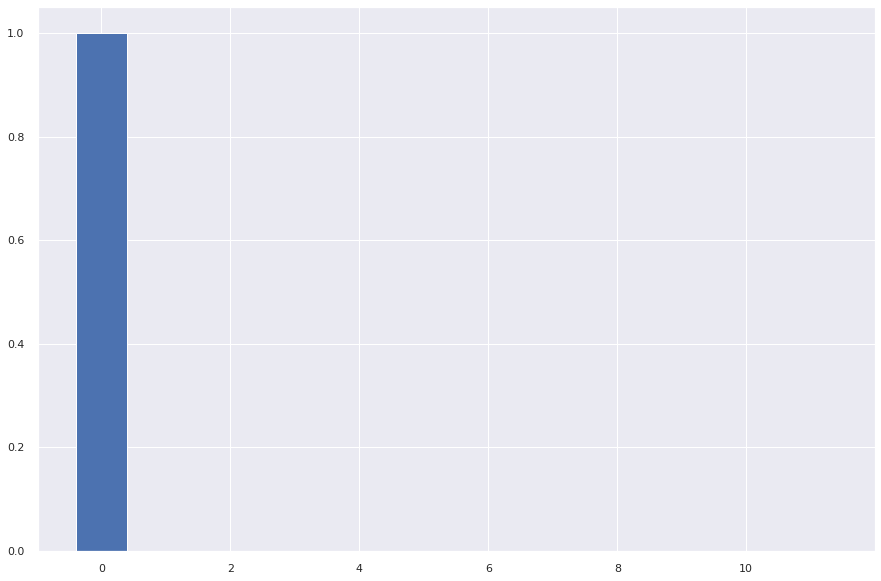

In [73]:
# model
pca = PCA(n_components=X.shape[1])

# fit
principal_components = pca.fit_transform(X)

# plot explained variable
features = range(pca.n_components)

plt.bar(features, pca.explained_variance_ratio_)

# pca component
df_pca = pd.DataFrame(principal_components)

In [74]:
df_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,2548.880047,-0.291807,0.713432,-0.034767,0.073940,-0.124036,0.068008,0.972944,0.188882,-0.005939,-0.000824,-0.000070
1,-2254.119955,0.422086,0.094348,-0.020983,-0.013786,-0.006676,0.004504,0.000273,-0.004671,0.003972,-0.000390,-0.000342
2,-2718.119955,0.557751,0.093815,-0.030469,0.029010,-0.006594,-0.002839,0.001280,-0.008214,-0.007473,0.000597,0.001070
3,-1553.119954,0.160987,0.125028,-0.052353,-0.023094,0.004198,-0.000221,-0.000136,-0.002762,0.001543,-0.000994,-0.000120
4,-201.119953,-0.139262,0.690564,-0.035788,-0.033016,0.014342,0.000934,-0.002532,0.001582,0.003507,-0.003127,0.002528


<AxesSubplot:xlabel='0', ylabel='1'>

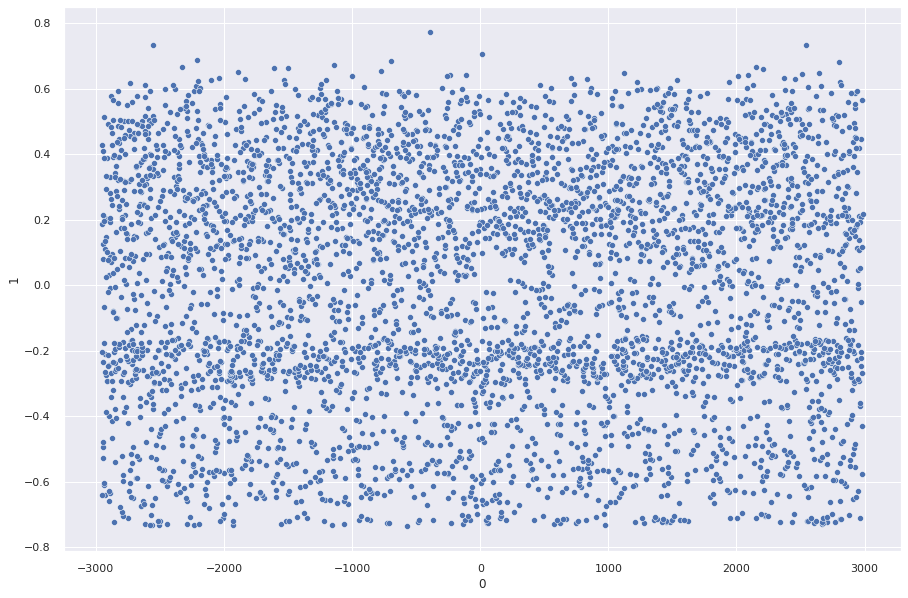

In [75]:
sns.scatterplot(x=0, y=1, data=df_pca)

### 4.3.2 UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

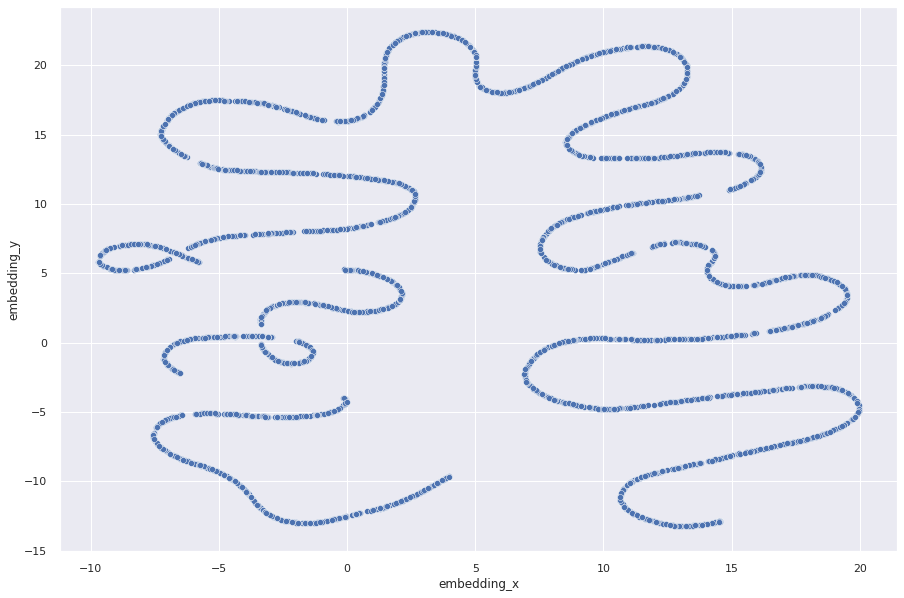

In [76]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_umap = pd.DataFrame()
df_umap['embedding_x'] = embedding[: , 0]
df_umap['embedding_y'] = embedding[: , 1]

# plot UMAP
plt.figure(figsize=(15, 10))
sns.scatterplot(x='embedding_x', y='embedding_y',
                data=df_umap)

### 4.3.3 t-SNE

/home/jonas/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jonas/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

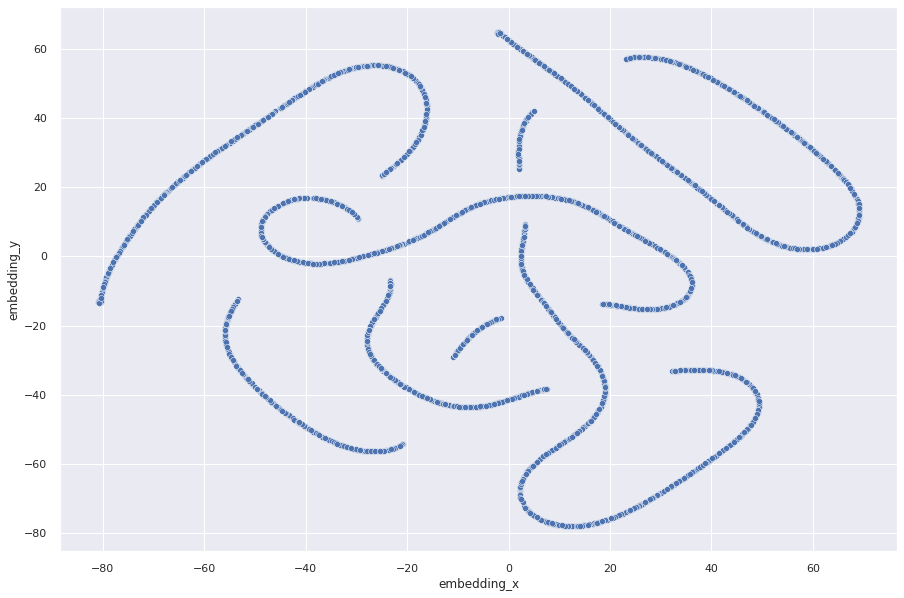

In [77]:
reducer = TSNE(n_components=2, n_jobs=-1, random_state=42)

embedding = reducer.fit_transform(X)

# embedding
df_tsne = pd.DataFrame()
df_tsne['embedding_x'] = embedding[: , 0]
df_tsne['embedding_y'] = embedding[: , 1]

# plot UMAP
plt.figure(figsize=(15, 10))
sns.scatterplot(x='embedding_x', y='embedding_y',
                data=df_tsne)

### 4.3.4 Embedding baseado em árvores

In [46]:
df4.head()

,customer_id,monetary,recency_days,quant_invoices,quant_items,quant_prod_uniq,avg_ticket,avg_recency_day,freq_purchases,quant_returns,avg_basket_size,avg_uniq_basket_size
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,187.000000,34.000000,40.0,50.970588,0.617647
1,13047,3237.54,31.0,10.0,1391.0,172.0,18.822907,89.375000,0.029240,36.0,139.100000,10.600000
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.902500,49.600000,0.040431,50.0,335.200000,7.600000
3,13748,948.25,95.0,5.0,439.0,28.0,33.866071,162.750000,0.017986,0.0,87.800000,4.800000
4,15100,876.00,333.0,3.0,80.0,3.0,292.000000,137.666667,0.075000,22.0,26.666667,0.333333


In [44]:
X = df4.drop('monetary', axis=1)
y = df4['monetary'].copy()

In [45]:
# model defition
rf_model = RandomForestRegressor(n_estimators=2000,  random_state=42)

# fit 
rf_model.fit(X, y)

# Leaf
leaf = rf_model.apply(X)  # retorna os índices das folhas

# dataframe leaf
df_leaf = pd.DataFrame(leaf)

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

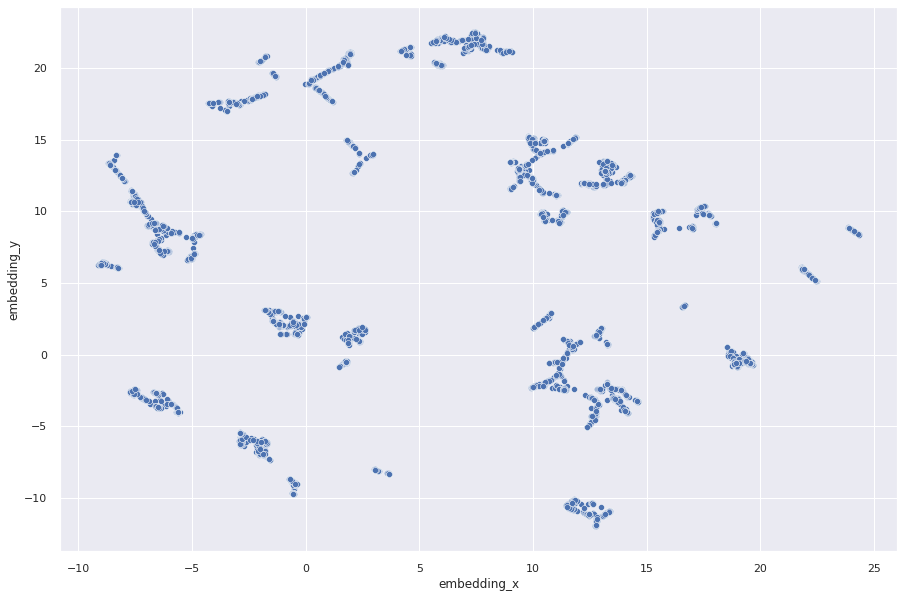

In [46]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_leaf)

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[: , 0]
df_tree['embedding_y'] = embedding[: , 1]


# plot UMAP
plt.figure(figsize=(15, 10))
sns.scatterplot(x='embedding_x', y='embedding_y',
                data=df_tree)

# 5 Preparação dos Dados

Resumo para preparação dos dados
- Distribuição Normal e Sem Outlier -> Standard Scaler
- Distribuição Normal e Com Outlier -> Robust Scaler
- Não é normalmente distribuído -> MinMaxScaler

**Teste de Normalidade:**
- QQ Plot (Quantile Quantile  Plot) -> Se o gráfico for próximo de uma reta, então a distribuição é próxima da Normal.
- KS Teste (Kolmogorov–Smirnov Test) (Teste de Hipótese) -> 

**Detecção de Outliers**
- Box Plot
- IRQ * 2.5
- z-Score > 3 ou Z-Score < -3

In [47]:
df5 = df_tree.copy()

In [48]:
df5.columns

Index(['embedding_x', 'embedding_y'], dtype='object')

Pelo testes realizados, optei por utilizar o MinMaxScaler em todos atributos.

# 6 Seleção dos Atributos

In [49]:
df6 = df5.copy()

Todos os atributos foram selecionados.

# 7 Hyperparameter Fine-Tunning

In [50]:
df7 = df6.copy()

In [51]:
X = df7.copy()

In [52]:
clusters = list(np.arange(2, 21, 1))

## 7.1 K-Means

In [90]:
kmeans_list = []
for k in clusters:
    # model
    kmeans_model = KMeans(n_clusters=k)

    # treino
    kmeans_model.fit(X)

    # clustering
    labels = kmeans_model.predict(X)

    # performance
    sil = silhouette_score(X, labels)   
    kmeans_list.append(sil)

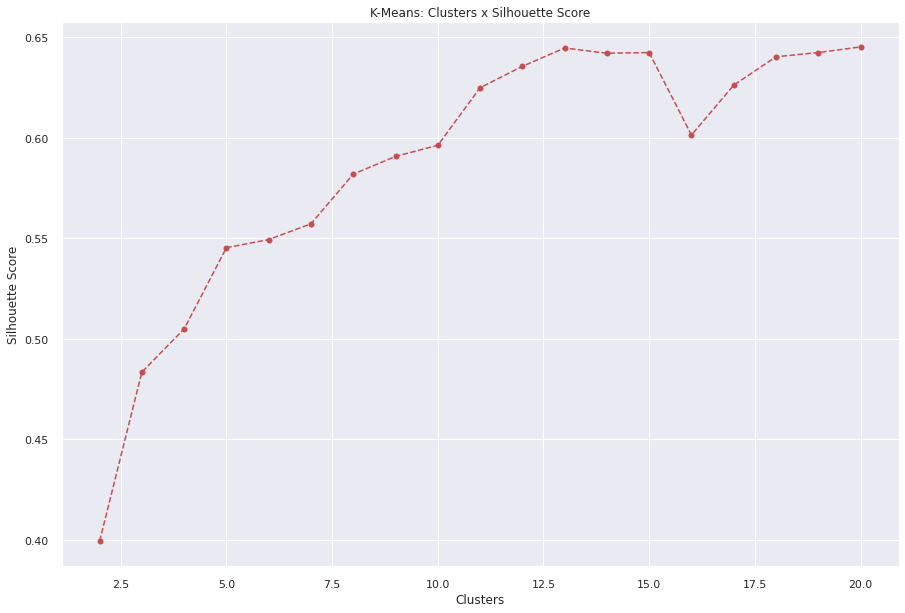

In [91]:
plt.plot(clusters, kmeans_list, linestyle='--', marker='o', color='r')
plt.xlabel('Clusters')
plt.ylabel('Silhouette Score')
plt.title('K-Means: Clusters x Silhouette Score');

## 7.2 GMM

In [92]:
gmm_list = []
for k in clusters:
    # model
    gmm_model = GaussianMixture(n_components=k)

    # treino
    gmm_model.fit(X)

    # clustering
    labels = gmm_model.predict(X)

    # performance
    sil = silhouette_score(X, labels)
    gmm_list.append(sil)

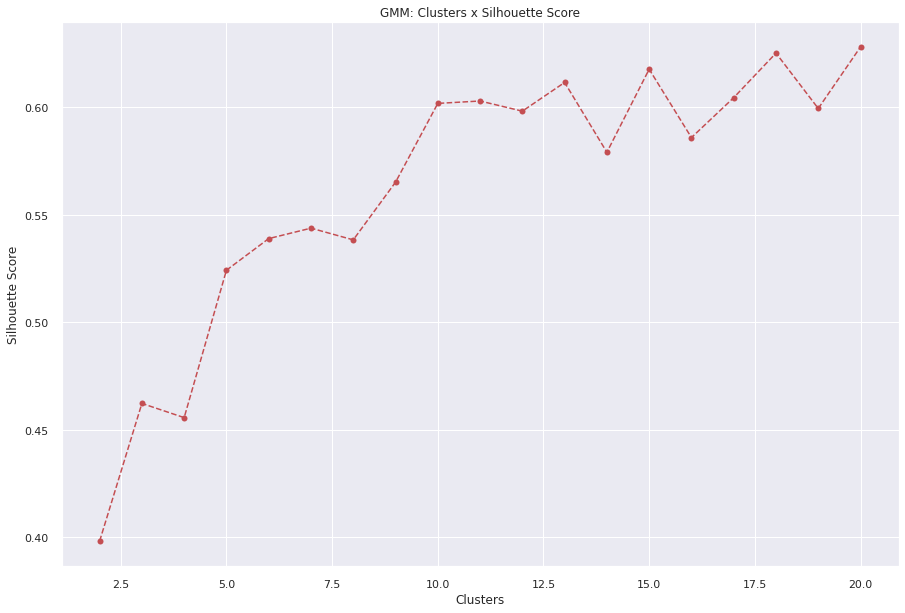

In [93]:
plt.plot(clusters, gmm_list, linestyle='--', marker='o', color='r')
plt.xlabel('Clusters')
plt.ylabel('Silhouette Score')
plt.title('GMM: Clusters x Silhouette Score');

## 7.3 Clusterização  Hierárquica 

In [94]:
hc_list = []
for k in clusters:
    # model
    hc_model = AgglomerativeClustering(n_clusters=k)

    # treino predict
    labels  = hc_model.fit_predict(X)

    # performance
    sil = silhouette_score(X, labels)
    hc_list.append(sil)

Text(0.5, 1.0, 'HC: Silhouette Score x Clusters')

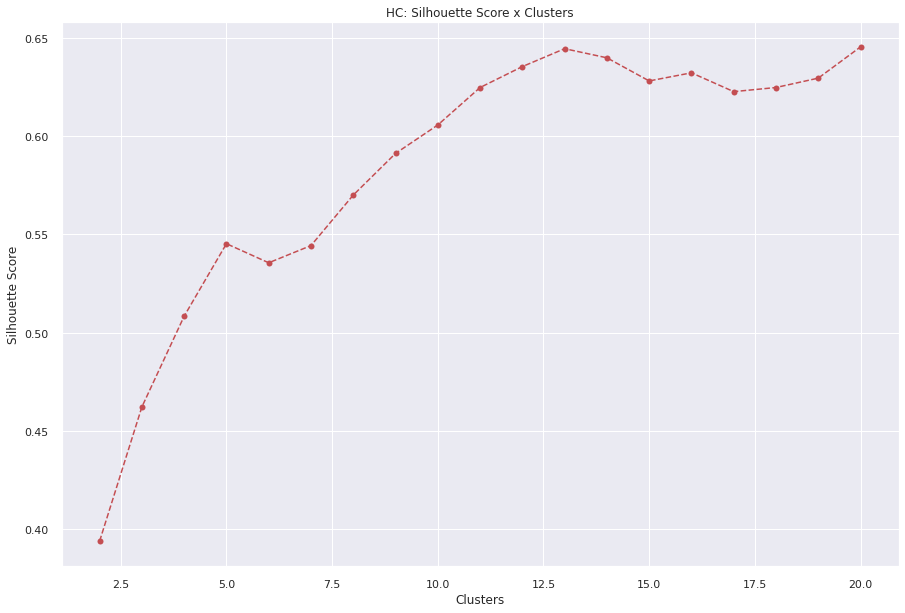

In [95]:
plt.plot(clusters, hc_list, linestyle='--', marker='o', color='r')
plt.xlabel('Clusters')
plt.ylabel('Silhouette Score')
plt.title('HC: Silhouette Score x Clusters')

### 7.3.1 Dendrograma

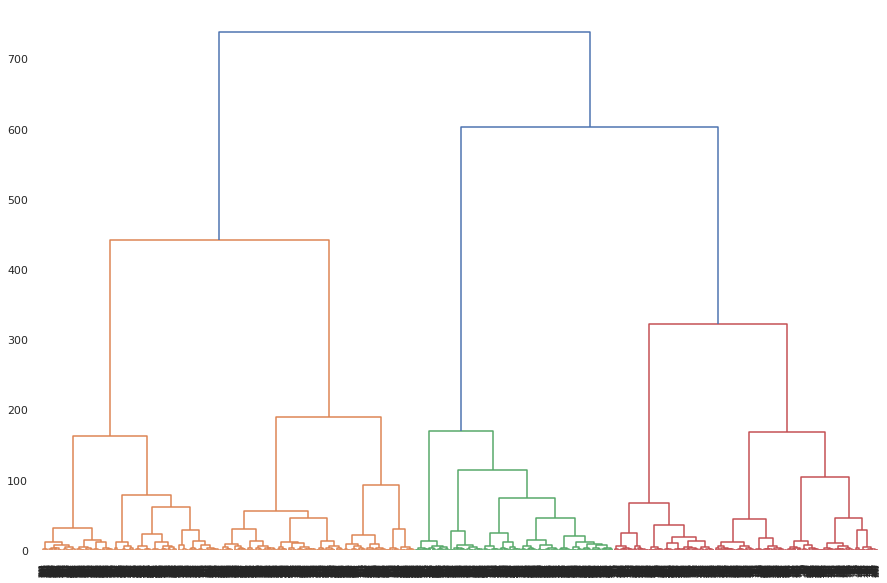

In [96]:
# model, treino, predict
hc_model = linkage(X, method='ward')

# dendrograma
dendrogram(hc_model)

plt.plot();

## 7.4 DBSCAN

In [97]:
r_list = list(np.arange(3, 5.1, 0.1))
n_list = list(np.arange(30, 56, 2))

for r in r_list:
    for n in n_list:
        # model
        dbscan_model = DBSCAN(eps=r, min_samples=n, metric='manhattan')

        # treino predict
        labels = dbscan_model.fit_predict(X)

        # performance
        sil = silhouette_score(X, labels)
                
        print(f'Para r = {round(r, 1)} e n = {n}, formamos {max(np.unique(labels))+1} clusters e ss = {sil}')

Para r = 3.0 e n = 30, formamos 14 clusters e ss = 0.5820000171661377
Para r = 3.0 e n = 32, formamos 14 clusters e ss = 0.5820000171661377
Para r = 3.0 e n = 34, formamos 14 clusters e ss = 0.5820000171661377
Para r = 3.0 e n = 36, formamos 14 clusters e ss = 0.5820000171661377
Para r = 3.0 e n = 38, formamos 13 clusters e ss = 0.5849999785423279
Para r = 3.0 e n = 40, formamos 13 clusters e ss = 0.5849999785423279
Para r = 3.0 e n = 42, formamos 13 clusters e ss = 0.5849999785423279
Para r = 3.0 e n = 44, formamos 13 clusters e ss = 0.5849999785423279
Para r = 3.0 e n = 46, formamos 13 clusters e ss = 0.5849999785423279
Para r = 3.0 e n = 48, formamos 13 clusters e ss = 0.5849999785423279
Para r = 3.0 e n = 50, formamos 13 clusters e ss = 0.5849999785423279
Para r = 3.0 e n = 52, formamos 13 clusters e ss = 0.5849999785423279
Para r = 3.0 e n = 54, formamos 13 clusters e ss = 0.5849999785423279
Para r = 3.1 e n = 30, formamos 14 clusters e ss = 0.5820000171661377
Para r = 3.1 e n = 3

Para r = 3.9 e n = 32, formamos 12 clusters e ss = 0.6039999723434448
Para r = 3.9 e n = 34, formamos 12 clusters e ss = 0.6039999723434448
Para r = 3.9 e n = 36, formamos 12 clusters e ss = 0.6039999723434448
Para r = 3.9 e n = 38, formamos 11 clusters e ss = 0.6169999837875366
Para r = 3.9 e n = 40, formamos 11 clusters e ss = 0.6169999837875366
Para r = 3.9 e n = 42, formamos 11 clusters e ss = 0.6169999837875366
Para r = 3.9 e n = 44, formamos 11 clusters e ss = 0.6169999837875366
Para r = 3.9 e n = 46, formamos 11 clusters e ss = 0.6169999837875366
Para r = 3.9 e n = 48, formamos 11 clusters e ss = 0.6169999837875366
Para r = 3.9 e n = 50, formamos 11 clusters e ss = 0.6169999837875366
Para r = 3.9 e n = 52, formamos 11 clusters e ss = 0.6169999837875366
Para r = 3.9 e n = 54, formamos 11 clusters e ss = 0.6169999837875366
Para r = 4.0 e n = 30, formamos 12 clusters e ss = 0.6039999723434448
Para r = 4.0 e n = 32, formamos 12 clusters e ss = 0.6039999723434448
Para r = 4.0 e n = 3

Para r = 4.8 e n = 34, formamos 9 clusters e ss = 0.6000000238418579
Para r = 4.8 e n = 36, formamos 9 clusters e ss = 0.6000000238418579
Para r = 4.8 e n = 38, formamos 9 clusters e ss = 0.6000000238418579
Para r = 4.8 e n = 40, formamos 9 clusters e ss = 0.6000000238418579
Para r = 4.8 e n = 42, formamos 9 clusters e ss = 0.6000000238418579
Para r = 4.8 e n = 44, formamos 9 clusters e ss = 0.6000000238418579
Para r = 4.8 e n = 46, formamos 9 clusters e ss = 0.6000000238418579
Para r = 4.8 e n = 48, formamos 9 clusters e ss = 0.6000000238418579
Para r = 4.8 e n = 50, formamos 9 clusters e ss = 0.6000000238418579
Para r = 4.8 e n = 52, formamos 9 clusters e ss = 0.6000000238418579
Para r = 4.8 e n = 54, formamos 9 clusters e ss = 0.6000000238418579
Para r = 4.9 e n = 30, formamos 9 clusters e ss = 0.6000000238418579
Para r = 4.9 e n = 32, formamos 9 clusters e ss = 0.6000000238418579
Para r = 4.9 e n = 34, formamos 9 clusters e ss = 0.6000000238418579
Para r = 4.9 e n = 36, formamos 9 

Valores de $r$ e $n$ para testar:

- $r = 3.0$ e $n = 30$ $(k=14)$
- $r = 3.4$ e $n = 30$ $(k=13)$
- $r = 3.3$ e $n = 54$ $(k=12)$
- $r = 3.5$ e $n = 38$ $(k=11)$
- $r = 4.1$ e $n = 38$ $(k=10)$
- $r = 4.8$ e $n = 30$ $(k=9)$

In [107]:
r = 3
n = 30
# model
dbscan_model = DBSCAN(eps=r, min_samples=n, metric='manhattan')

# treino predict
labels = dbscan_model.fit_predict(X)

# performance
sil = silhouette_score(X, labels)
sil

0.58178025

In [122]:
dbscan_list = [0, 0, 0, 0, 0, 0, 0, 0.6002778, 0.602339, 0.617387, 0.612697, 0.60953087, 0.58178025, 0, 0, 0, 0, 0, 0]

In [123]:
# from sklearn.neighbors import NearestNeighbors

In [124]:
# neighbors = NearestNeighbors(n_neighbors=n).fit(X)

# distances, indices = neighbors.kneighbors(X)

# distances = np.sort(distances, axis=0)
# distances = distances[:, 1]

In [125]:
# # Curva Cotovelo
# plt.plot(distances);
# plt.axhline(y=0.1, linestyle='--', c='r')

## 7.5 Resultados

In [126]:
df_results = pd.DataFrame({'K-Means': kmeans_list, 
                           'GMM': gmm_list,
                           'HC': hc_list,
                           'DBSCAN': dbscan_list}).T
df_results.columns = clusters

In [127]:
df_results.style.highlight_max(color = 'lightgreen', axis=1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
K-Means,0.399370,0.483406,0.504899,0.545254,0.549289,0.557141,0.581811,0.590637,0.596169,0.624771,0.635429,0.644541,0.641937,0.642272,0.601259,0.626057,0.640173,0.642279,0.645084
GMM,0.398059,0.462161,0.455555,0.524204,0.538926,0.543790,0.538340,0.565188,0.601886,0.603003,0.598277,0.611632,0.579129,0.617803,0.585968,0.604560,0.625306,0.599522,0.628194
HC,0.393849,0.462161,0.508360,0.545254,0.535542,0.544301,0.570006,0.591215,0.605696,0.624771,0.635429,0.644541,0.639903,0.628125,0.632258,0.622680,0.624778,0.629544,0.645448
DBSCAN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.600278,0.602339,0.617387,0.612697,0.609531,0.581780,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# 8 Treinamento do Modelo

In [53]:
df8 = df7.copy()

In [54]:
# X = df8.drop('customer_id', axis=1)
X = df8.copy()

## 8.1 KMeans

In [160]:
# model definion
k = 12
kmeans = KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=271)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

## 8.2 GMM

In [148]:
# model
k = 12
gmm_model = GaussianMixture(n_components=k)

# treino
gmm_model.fit(X)

# clustering
labels = gmm_model.predict(X)

## 8.3 HC

In [60]:
# modeL
k = 12
hc_model = AgglomerativeClustering(n_clusters=k)

# treino predict
labels  = hc_model.fit_predict(X)

# saving model
pickle.dump(hc_model, open('/home/jonas/Documentos/repos/insiders_clustering/model/hc_model.pkl', 'wb'))

## 8.4 DBSCAN

- $r = 3.0$ e $n = 30$ $(k=14)$
- $r = 3.4$ e $n = 30$ $(k=13)$
- $r = 3.3$ e $n = 54$ $(k=12)$
- $r = 3.5$ e $n = 38$ $(k=11)$
- $r = 4.1$ e $n = 38$ $(k=10)$
- $r = 4.8$ e $n = 30$ $(k=9)$

In [154]:
r = 3.3
n = 54
# model
dbscan_model = DBSCAN(eps=r, min_samples=n, metric='manhattan')

# treino predict
labels = dbscan_model.fit_predict(X)

# 9 Análise dos Clusters

In [61]:
df9 = df8.copy()

# load model
model = pickle.load(open('/home/jonas/Documentos/repos/insiders_clustering/model/hc_model.pkl', 'rb'))
labels  = model.fit_predict(X)

df9['clusters'] = labels

## 9.1 Inspeção por Visualização

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

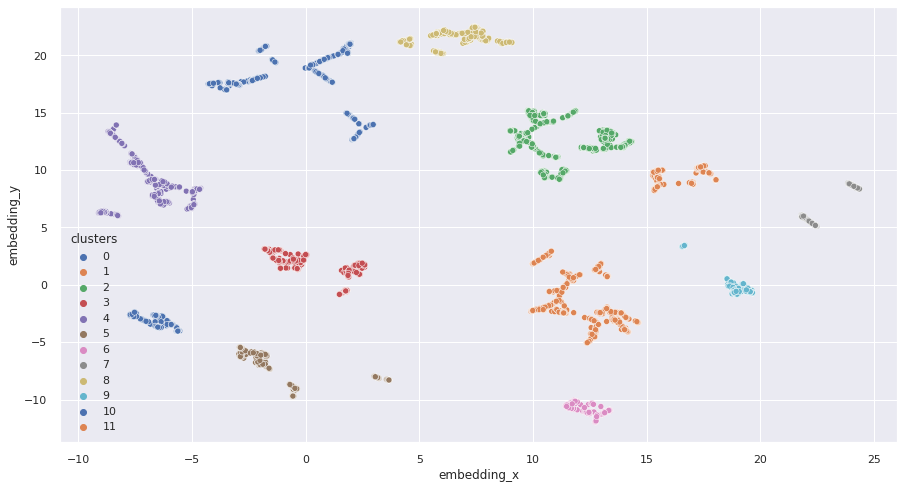

In [62]:
plt.figure(figsize=(15, 8))
sns.scatterplot(data=df9, x='embedding_x', y='embedding_y', hue='clusters', palette='deep')

Após analisar diversas possibilidades, optei por utilizar o modelo de **Clustering Hierárquico** com **12 clusters**.

## 9.2 Perfil dos Clusters

In [63]:
df92 = df4.copy()
df92['clusters'] = df9['clusters']

In [64]:
df92.head()

,customer_id,monetary,recency_days,quant_invoices,quant_items,quant_prod_uniq,avg_ticket,avg_recency_day,freq_purchases,quant_returns,avg_basket_size,avg_uniq_basket_size,clusters
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,187.000000,34.000000,40.0,50.970588,0.617647,3.0
1,13047,3237.54,31.0,10.0,1391.0,172.0,18.822907,89.375000,0.029240,36.0,139.100000,10.600000,3.0
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.902500,49.600000,0.040431,50.0,335.200000,7.600000,5.0
3,13748,948.25,95.0,5.0,439.0,28.0,33.866071,162.750000,0.017986,0.0,87.800000,4.800000,0.0
4,15100,876.00,333.0,3.0,80.0,3.0,292.000000,137.666667,0.075000,22.0,26.666667,0.333333,1.0


In [66]:
# Number of Clusters
df_clusters = df92[['customer_id', 'clusters']].groupby('clusters').count().reset_index()
df_clusters['customer_perc'] = 100*(df_clusters['customer_id'] / df_clusters['customer_id'].sum())

# AVG Monetary
df_avg_monetary = df92[['monetary', 'clusters']].groupby('clusters').mean().reset_index()
df_clusters = df_clusters.merge(df_avg_monetary, on='clusters')
df_clusters['monetary_avg_perc'] = 100*(df_clusters['monetary'] / df_clusters['monetary'].sum())

# AVG Recency_days
df_avg_recency = df92[['recency_days', 'clusters']].groupby('clusters').mean().reset_index()
df_clusters = df_clusters.merge(df_avg_recency, on='clusters')

# AVG quant_invoices
df_avg_invoices = df92[['quant_invoices', 'clusters']].groupby('clusters').mean().reset_index()
df_clusters = df_clusters.merge(df_avg_invoices, on='clusters')

# # AVG quant_items
# df_avg_items = 

# AVG Frequency
df_avg_freq = df92[['freq_purchases', 'clusters']].groupby('clusters').mean().reset_index()
df_clusters = df_clusters.merge(df_avg_freq, on='clusters')

# AVG quant_returns
df_avg_returns = df92[['quant_returns', 'clusters']].groupby('clusters').mean().reset_index()
df_clusters = df_clusters.merge(df_avg_returns, on='clusters')

# Rename columns
df_clusters.columns = ['clusters', 'num_customer', 'customer_perc', 'monetary_avg', 'monetary_avg_perc', 'recency_days_avg', 'quant_invoices_avg', 'frequency_avg', 'quant_returns_avg']

In [67]:
df_clusters

,clusters,num_customer,customer_perc,monetary_avg,monetary_avg_perc,recency_days_avg,quant_invoices_avg,frequency_avg,quant_returns_avg
0,0.0,549,12.764473,1379.255956,5.556288,95.240437,3.455373,0.026721,18.371585
1,1.0,672,15.624273,1164.716949,4.692024,92.125000,3.026786,0.039930,9.360119
2,2.0,640,14.880260,1366.175109,5.503592,89.895313,3.323437,0.025009,12.568750
3,3.0,365,8.486399,3233.649178,13.026650,88.547945,5.413699,0.128275,35.539726
4,4.0,517,12.020460,2349.992669,9.466869,103.794971,4.980658,0.030719,30.928433
5,5.0,291,6.765868,5417.282577,21.823346,85.209622,10.769759,0.034105,122.494845
6,6.0,178,4.138572,2125.077921,8.560807,104.050562,3.297753,0.049991,483.207865
7,7.0,144,3.348059,925.022083,3.726421,88.847222,2.527778,0.033112,5.125000
8,8.0,375,8.718903,1377.698933,5.550015,81.786667,3.381333,0.029764,9.970667
9,9.0,175,4.068821,1232.021029,4.963157,104.131429,3.531429,0.030254,13.062857


- Cluster 05: Campeões
- Cluster 03: 
- Cluster 10: 
- Cluster 04:
- Cluster 06:
- Cluster 00:
- Cluster 08:
- Cluster 02:
- Cluster 09:
- Cluster 11:
- Cluster 01:
- Cluster 07:

# 10 Análise Exploratória dos Dados

## 10.1 Mapa Mental de Hipóteses

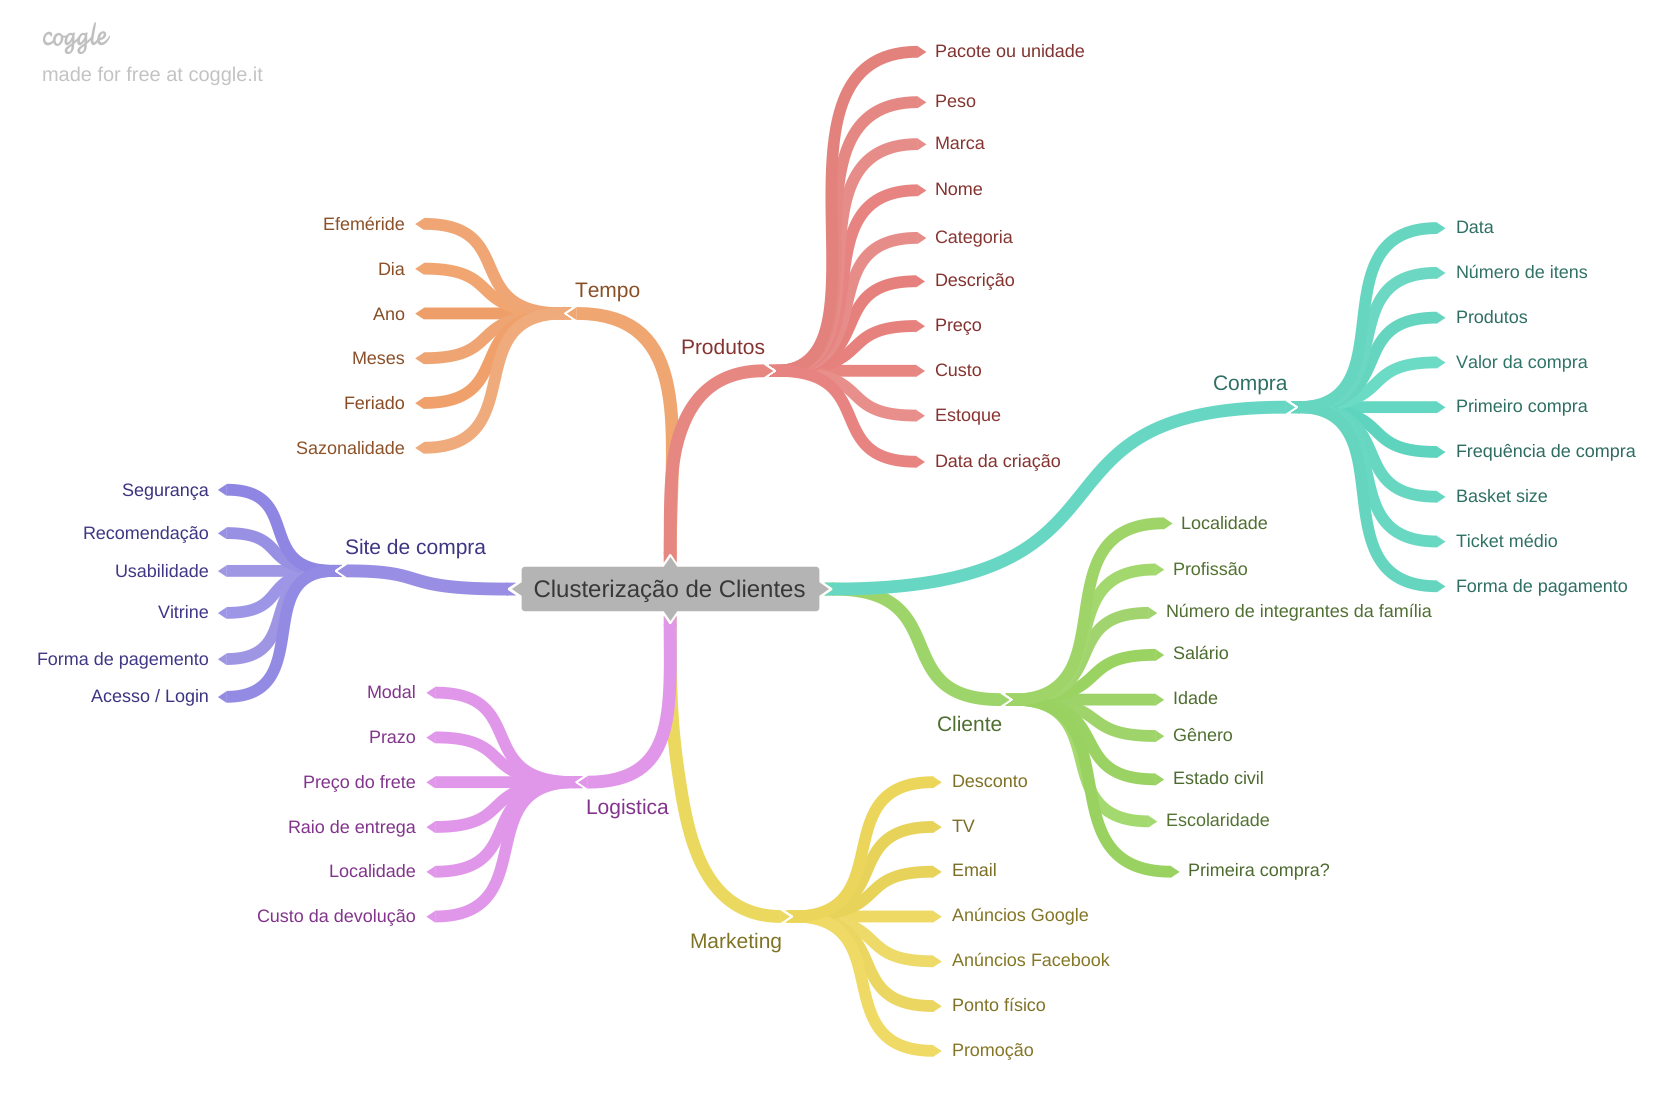

In [69]:
Image('Clusterizao_de_Clientes.png')

## 10.2 Hipóteses de Compras

1. Os clientes do cluster insiders usam cartão de crédito em 80% das compras.
 
2. Os clientes do cluster insiders possuem um ticket médio de 10% acima do cluster More Products
 
3. Os clientes do cluster insiders possuem um basket size acima de 5 produtos
 
4. Os clientes do cluster insiders possuem um volume (produtos) de compras acima de 10% do total de compras
 
5. Os clientes do cluster insiders possuem um volume (faturamento) de compras acima de 10% do total de compras
 
6. Os clientes do cluster insiders tem um número de devolução abaixo da média da base total de clientes
 
7. A mediana do faturamento pelos clientes do cluster insider é 10% maior do que a mediana do faturamento geral.
 
8. O percentil do gmv pelos clientes insiders.

## 10.3 Hipóteses de Clientes

1. 60% dos clientes do cluster insiders possuem o estado civil de solteiro.

2. 10% dos clientes do cluster insiders estão na faixa de 24-35 anos.

3. 40% das localidades de entrega do cluster insiders estão dentro de um raio de 50km.

4. 5% dos clientes do cluster insiders recebem mais de 100 mil dólares anualmente.

5. 90% dos clientes do cluster insiders tem ensino superior completo.

## 10.4 Hipóteses de Produtos

1. 30% de todos os produtos em pacotes grandes são comprados pelos clientes do cluster insiders.

2. A mediana dos preços dos produtos comprados pelos clientes do cluster insider é 10% maior do que a mediana de todos os preços dos produtos.

3. O percentil do preço dos produtos comprados pelos clientes insiders. ??

4. O peso médio dos produtos comprados pelos clientes do cluster insiders é maior do que o peso médio dos outros clusters.

5. A idade média dos produtos comprados pelos clientes do cluster insiders é menor do que 15 dias.

## 10.5 Perguntas de Negócio

- Quem são as pessoas elegíveis para participar do programa de Insiders ?
- Quantos clientes farão parte do grupo ?
- Quais as principais características desses clientes ?
- Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
- Qual a expectativa de faturamento desse grupo para os próximos meses ?
- Quais as condições para uma pessoa ser elegível ao Insiders ?
- Quais as condições para uma pessoa ser removida do Insiders ?
- Qual a garantia que o programa Insiders é melhor que o restante da base ?
- Quais ações o time de marketing pode realizar para aumentar o faturamento ?

# 11 Deploy do Modelo em Produção